<a href="https://colab.research.google.com/github/mtwenzel/image-video-understanding/blob/master/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Attention by Example

Partially taken from https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a#8481

In [1]:
#@title Imports
import torch
from torch.nn.functional import softmax

import seaborn as sns

## Create a tensor with input data.

In a real setting, this tensor would be the result of some data encoding step (when considering the first input to the first attention layer), or the result of the previous attention layer.

If for example your input is text, and your word embeddings have 512 dimensions, each row in the tensor $x$ would have 512 entries, and the tensor would have as many rows as your sentence has words.

For images (here described along the lines of the ViT), the number of rows in $x$ is the number of tiles the images get subdivided into ($16 \times 16$ in ViT). The length of each line is the length of the embedding vector after transforming each tile with the patch encoder. [See the ViT publication for details](https://arxiv.org/abs/2010.11929)

Note that there is the embedding size of the original data, but also the internal encoding size that will be determined by the shape of the K, Q, and V matrices.

In [16]:
#@title Define data matrix {run:"auto"}
#@markdown We randomly create data of a given size. Set the number of tokens and the encoding/embedding length here.
num_tokens = 5 #@param {type:"slider", min:"1", max:"16"}
num_embedding_features = 9 #@param {type:"slider", min:"1", max:"32"}

x = torch.rand([num_tokens,num_embedding_features])
x

tensor([[0.6793, 0.5176, 0.0199, 0.9120, 0.0859, 0.9003, 0.9276, 0.0403, 0.1798],
        [0.6931, 0.4052, 0.2260, 0.4736, 0.2019, 0.6505, 0.2414, 0.7504, 0.3757],
        [0.3532, 0.3325, 0.7906, 0.8660, 0.5642, 0.5118, 0.1607, 0.9036, 0.9604],
        [0.9106, 0.5106, 0.1056, 0.7703, 0.7784, 0.4557, 0.3079, 0.2220, 0.2668],
        [0.7827, 0.9905, 0.2080, 0.8886, 0.4728, 0.2884, 0.9055, 0.3018, 0.2290]])

In [3]:
#@title Define second data matrix for cross attention {run:"auto"}
#@markdown To demonstrate cross attention with smaller attention matrix analogous to Perceiver or DETR, create a "learned queries" matrix $x_2$
#@markdown For consistency, you can only adjust the number of tokens. The embedding dimension is kept from above.
num_ca_tokens = 2 #@param {type:"slider", min:"1", max:"10"}

x2 = torch.rand([num_ca_tokens, num_embedding_features])
x2

tensor([[0.8428, 0.0652, 0.4855, 0.0808, 0.4266, 0.4926, 0.1704, 0.2659, 0.1028],
        [0.8605, 0.4510, 0.6743, 0.3013, 0.7022, 0.2031, 0.4545, 0.4177, 0.0018]])

## Create a set of weight tensors. 
We are looking at single-head attention only for the moment. For multi-head attention, each weight matrix would be replicated (with independent weights) for each head. You will see this in the second half of the notebook.

Each weight tensor has to have as many rows as the tokens have dimensions. Our input vectors have ```num_embedding_features``` dimensions. Let's create random weight matrices of the according size. You are free to select the other dimension, which will then be the internal embedding dimension.

Observe how the size of these matrices does not depend on the number of tokens anymore.

Note that this will result in a matrix output after the attention mechanism, instead of a single token.

In [5]:
#@title Get K, Q, V transform matrices {run:"auto"}

internal_embedding_dimensions = 7 #@param {type:"slider", min:"1", max:"32"}

w_key = torch.rand([num_embedding_features,internal_embedding_dimensions])
w_query = torch.rand([num_embedding_features,internal_embedding_dimensions])
w_value = torch.rand([num_embedding_features,internal_embedding_dimensions])

## K, Q, and V

The actual keys, querys and values are the result of the multiplication of input tensor with weight tensors.

Their dimension is:
* each row has as many entries as the weight tensors (three in our setup)
* the number of rows equals the number of input tokens (five in our setup)

In [15]:
keys = x @ w_key
querys = x @ w_query
values = x @ w_value

# This would be the cross attention with a potentially different number of tokens
xattn_q = x2 @ w_query


print("Keys:",keys)
print("Queries:",querys)
print("Cross-attention Queries:",xattn_q)
print("Values:",values)

RuntimeError: ignored

## Softmax Attention

The size of the square attention matrix equals the number of input tokens in both dimensions. 

tensor([[0.0000, 0.0500, 0.9500, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.9900, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0200, 0.9800, 0.0000, 0.0000],
        [0.0000, 0.0400, 0.9500, 0.0000, 0.0000]])


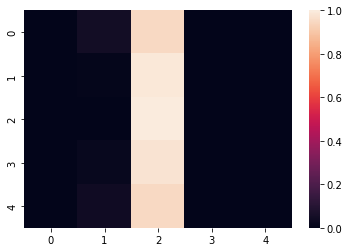

In [7]:
attn_scores = querys @ keys.T
attn_scores_softmax = softmax(attn_scores, dim=-1)

# For readability, round the scores to a definable number of decimal place.
decimal_places = 2
attn_scores_softmax = (attn_scores_softmax * 10**decimal_places).round() / (10**decimal_places)
print(attn_scores_softmax)

# Plot self attention matrix
t = attn_scores_softmax.numpy()
sns.heatmap(t)

## Do the same for "cross attention"

tensor([[0.0000, 0.0800, 0.9200, 0.0000, 0.0000],
        [0.0000, 0.0300, 0.9700, 0.0000, 0.0000]])


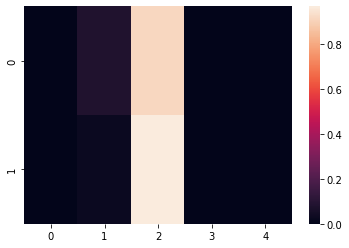

In [8]:
attn_scores = xattn_q @ keys.T
attn_scores_softmax = softmax(attn_scores, dim=-1)

# For readability, round the scores to a definable number of decimal place.
decimal_places = 2
attn_scores_softmax = (attn_scores_softmax * 10**decimal_places).round() / (10**decimal_places)
print(attn_scores_softmax)

# Plot self attention matrix
t = attn_scores_softmax.numpy()
sns.heatmap(t)

## Multiply softmax attention with V to obtain the result

In a transformer, dense layers would follow that can 
* reduce a multi-head attention result
* enforce correct dimensionality to use output in next input.

We will see this after the following experiment with multi-head attention.

In [9]:
weighted_values = values[:,None] * attn_scores_softmax.T[:,:,None]
outputs = weighted_values.sum(dim=0)
print(outputs)

tensor([[2.3158, 3.0597, 2.6203, 3.4243, 2.7460, 3.3650, 2.2939],
        [2.3519, 3.0733, 2.6202, 3.4325, 2.7404, 3.3526, 2.2857]])


# Multi-Head Attention

In [26]:
#@title Define number of heads, and create according random weight matrices K, Q, V {run:"auto"}
#@markdown The only required change is to stack multiple K, Q, V. 

num_heads = 4 #@param {type:"slider", min:"2", max:"10"}

w_key = torch.rand([num_heads, num_embedding_features,internal_embedding_dimensions])
w_query = torch.rand([num_heads,num_embedding_features,internal_embedding_dimensions])
w_value = torch.rand([num_heads,num_embedding_features,internal_embedding_dimensions])
w_key

tensor([[[0.2733, 0.7812, 0.7641, 0.3052, 0.4567, 0.9450, 0.4532],
         [0.4498, 0.9423, 0.6074, 0.0151, 0.3515, 0.6659, 0.7264],
         [0.3161, 0.3739, 0.8842, 0.4183, 0.2884, 0.0401, 0.3216],
         [0.4397, 0.1095, 0.3900, 0.2027, 0.6039, 0.9574, 0.1609],
         [0.4012, 0.6240, 0.8823, 0.0674, 0.4679, 0.8012, 0.5658],
         [0.3115, 0.5811, 0.0562, 0.3933, 0.9291, 0.9854, 0.7168],
         [0.6841, 0.4065, 0.8962, 0.2717, 0.7119, 0.2735, 0.1564],
         [0.2171, 0.2496, 0.2217, 0.1499, 0.9656, 0.5199, 0.5577],
         [0.1759, 0.0689, 0.7043, 0.5086, 0.3233, 0.7810, 0.8019]],

        [[0.5563, 0.7499, 0.9050, 0.7064, 0.9931, 0.6419, 0.7703],
         [0.4445, 0.6988, 0.7100, 0.0419, 0.9103, 0.5601, 0.3187],
         [0.8106, 0.1023, 0.9072, 0.5147, 0.3790, 0.6388, 0.2224],
         [0.4746, 0.0314, 0.5566, 0.3866, 0.8606, 0.6279, 0.0491],
         [0.6473, 0.3451, 0.0674, 0.1621, 0.8616, 0.9747, 0.2555],
         [0.9837, 0.5115, 0.3543, 0.8858, 0.4573, 0.5352, 0.

In [27]:
keys = x @ w_key
querys = x @ w_query

xattn_q = x2 @ w_query

values = x @ w_value

print(keys)
#print(querys)
#print(xattn_q)
#print(values)

tensor([[[1.8157, 2.1019, 2.2999, 1.1178, 2.6828, 3.2317, 1.8427],
         [1.3291, 1.8748, 2.0221, 1.0467, 2.5268, 2.9395, 2.0953],
         [1.7377, 1.9861, 3.0559, 1.5260, 3.0662, 3.6362, 2.7806],
         [1.6107, 2.2659, 2.6252, 0.9703, 2.3986, 3.4231, 2.0946],
         [2.1207, 2.6416, 3.2032, 1.0740, 2.8016, 3.5048, 2.2520]],

        [[2.4292, 1.5015, 2.7006, 2.0039, 3.2472, 2.5751, 1.5071],
         [2.0102, 1.5730, 2.7513, 1.9291, 2.5323, 2.2833, 1.6162],
         [2.6223, 1.6623, 3.5269, 2.1561, 3.3469, 3.2624, 1.7831],
         [2.3442, 1.7444, 2.5341, 1.7829, 3.3999, 2.8497, 1.6340],
         [2.5197, 1.8270, 3.3573, 1.8460, 3.9198, 3.1641, 1.5236]],

        [[2.3231, 2.8579, 1.7107, 2.5001, 1.7791, 1.5832, 1.9128],
         [2.6233, 2.7401, 1.8852, 2.2075, 1.7762, 1.6191, 1.4930],
         [3.2811, 3.2719, 2.1771, 3.5933, 2.6954, 1.6750, 2.3055],
         [3.0458, 2.5804, 2.2711, 2.3839, 2.2638, 1.3091, 1.7270],
         [3.1317, 3.1964, 2.5313, 3.1025, 2.5822, 1.3179, 

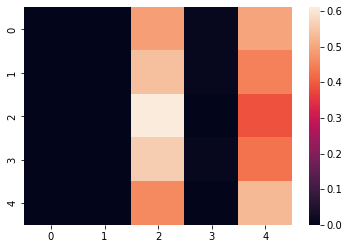

In [29]:
attn_scores = querys @ keys.mT 
attn_scores_softmax = softmax(attn_scores, dim=-1)

# For readability, round the scores to a definable number of decimal place.
decimal_places = 2
attn_scores_softmax = (attn_scores_softmax * 10**decimal_places).round() / (10**decimal_places)
#print(attn_scores_softmax)

# Plot self attention matrix
t = attn_scores_softmax.numpy()
sns.heatmap(t[0])
#sns.heatmap(t[1])

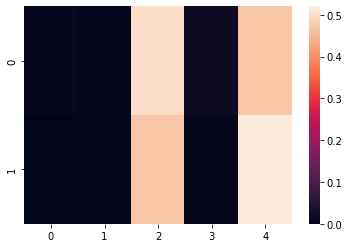

In [30]:
attn_scores = xattn_q @ keys.mT
attn_scores_softmax = softmax(attn_scores, dim=-1)

# For readability, round the scores to a definable number of decimal place.
decimal_places = 2
attn_scores_softmax = (attn_scores_softmax * 10**decimal_places).round() / (10**decimal_places)
#print(attn_scores_softmax)

# Plot self attention matrix
t = attn_scores_softmax.numpy()
sns.heatmap(t[0])

In [31]:
weighted_values = values[:,:,None] * attn_scores_softmax.mT[:,:,:,None]
outputs = weighted_values.sum(dim=0)
print(outputs)

tensor([[[0.0818, 0.0855, 0.0803, 0.0936, 0.0743, 0.0939, 0.0795],
         [0.0184, 0.0224, 0.0219, 0.0221, 0.0186, 0.0240, 0.0202]],

        [[0.0177, 0.0233, 0.0211, 0.0223, 0.0185, 0.0248, 0.0211],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[5.9505, 6.6217, 5.8784, 6.2094, 5.8684, 6.4434, 6.8259],
         [6.2310, 6.9971, 6.3772, 6.6083, 6.2805, 6.8952, 7.2370]],

        [[0.1511, 0.1489, 0.1283, 0.1514, 0.1225, 0.1803, 0.1577],
         [0.0502, 0.0425, 0.0347, 0.0472, 0.0357, 0.0520, 0.0469]],

        [[4.1549, 3.5221, 3.3135, 3.6626, 3.1550, 4.8024, 3.8495],
         [4.0737, 3.3455, 3.0813, 3.5800, 3.0462, 4.6270, 3.7075]]])


## Convert into expected shape for next layer

A MLP is employed to "fix the dimensions". We require

In [32]:
mlp_weights = torch.tensor([[0.6905, 0.9040, 0.8092, 0.0374],
        [0.7709, 0.1924, 0.0805, 0.0564],
        [0.1738, 0.0420, 0.3183, 0.0574],
        [0.7654, 0.7641, 0.9147, 0.6214],
        [0.9611, 0.7082, 0.8878, 0.8399],
        [0.5197, 0.7513, 0.5941, 0.5541]])

result = combined_heads @ mlp_weights

print(result)

NameError: ignored